In [17]:
#Imports
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score,recall_score,precision_score
from tqdm.notebook import tqdm
from tqdm import tqdm

In [18]:
#Model Parameters
batch_size = 64
learning_rate = 1e-4
Num_Epochs= 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
#Download Data and Dataloader
transform = transforms.Compose(
    [transforms.ToTensor()])

Train_Data = torchvision.datasets.CIFAR100(root='./data', train=True,download=True, transform=transform)
Train_Loader = torch.utils.data.DataLoader(Train_Data, batch_size=batch_size,shuffle=True)

Test_Data = torchvision.datasets.CIFAR100(root='./data', train=False,download=True, transform=transform)
Test_Loader = torch.utils.data.DataLoader(Test_Data, batch_size=batch_size,shuffle=False)

Train_Length = Train_Data.data.shape[0]
Test_Length = Test_Data.data.shape[0]

print("Training Shape: ",Train_Data.data.shape)
print("Training Shape: ", Test_Data.data.shape)


Files already downloaded and verified
Files already downloaded and verified
Training Shape:  (50000, 32, 32, 3)
Training Shape:  (10000, 32, 32, 3)


In [20]:
#Model Architecture
class CNN_Module(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), stride=(1,1))
        self.pool1=nn.MaxPool2d(2,2)
        self.pool2=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5), stride=(1,1))
        self.fc1=nn.Linear(3200,1024)
        self.fc2=nn.Linear(1024,100)
        
        self.relu1=nn.ReLU()
        self.relu2=nn.ReLU()
        self.relu3=nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [21]:
cnn = CNN_Module().to(device)
CE_Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = learning_rate)

In [22]:
training_loss_per_epoch=[]
training_accuracy_per_epoch=[]

testing_loss_per_epoch=[]
testing_accuracy_per_epoch=[]

f1_score_array=[]
recall_score_array=[]
precision_score_array=[]
pred = []
tar = []
counter = -1
for epoch in tqdm(range(Num_Epochs)):
    pool1_list, pool2_list = [], []
    train_loss = 0
    train_accuracy = 0
    
    test_loss = 0
    test_accuracy = 0

    epochtrainloss = []
    epochtestloss = []
    for i, data in enumerate(Train_Loader):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
    
        outputs = cnn(inputs)

        loss = CE_Loss(outputs, labels)
        
        _, predicted = torch.max(outputs.data,1)
        train_accuracy += torch.sum(predicted==labels).item()
        
        epochtrainloss.append(loss.item())
        loss.backward()
        optimizer.step()


        # print(activation['pool1'])
        # print(activation['pool2'])

    training_loss_per_epoch.append(np.mean(epochtrainloss))
    train_accuracy = train_accuracy/Train_Length
    training_accuracy_per_epoch.append(train_accuracy)
    cnn.eval()
    pred = []
    tar = []
    for i, data in enumerate(Test_Loader):
        inputs,labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        outputs = cnn(inputs)

        Testing_loss= CE_Loss(outputs, labels)
        _, predicted = torch.max(outputs.data,1)
        test_accuracy += torch.sum(predicted==labels).item()
        epochtestloss.append(Testing_loss.item())
        pred.extend(predicted.detach().cpu().numpy())
        tar.extend(labels.detach().cpu().numpy())

  
    testing_loss_per_epoch.append(np.mean(epochtestloss))
    test_accuracy = test_accuracy/Test_Length
    testing_accuracy_per_epoch.append(test_accuracy)

print(f1_score(tar,pred,average='macro'))
print(recall_score(tar,pred,average='macro'))
print(precision_score(tar,pred,average='macro'))   
    

100%|██████████| 100/100 [12:09<00:00,  7.29s/it]

0.1272032724058985
0.2006
0.09888348970790257



/rhome/acheruvu/anaconda3/envs/pytorch_acheruvu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print("Final Train Accuracy: ", training_accuracy_per_epoch[-1])
print("Final Train Loss: ", training_loss_per_epoch[-1])

print("Final Test Accuracy: ", testing_accuracy_per_epoch[-1])
print("Final Test Loss: ", testing_loss_per_epoch[-1])

Final Train Accuracy:  0.31876
Final Train Loss:  4.304228581430967
Final Test Accuracy:  0.2006
Final Test Loss:  4.422641538510657


In [24]:
# Number of convolution layers
model_weights = []
conv_layers = [] 
model_children = list(cnn.children())
counter = 0 
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [25]:

for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 3, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([128, 64, 5, 5])


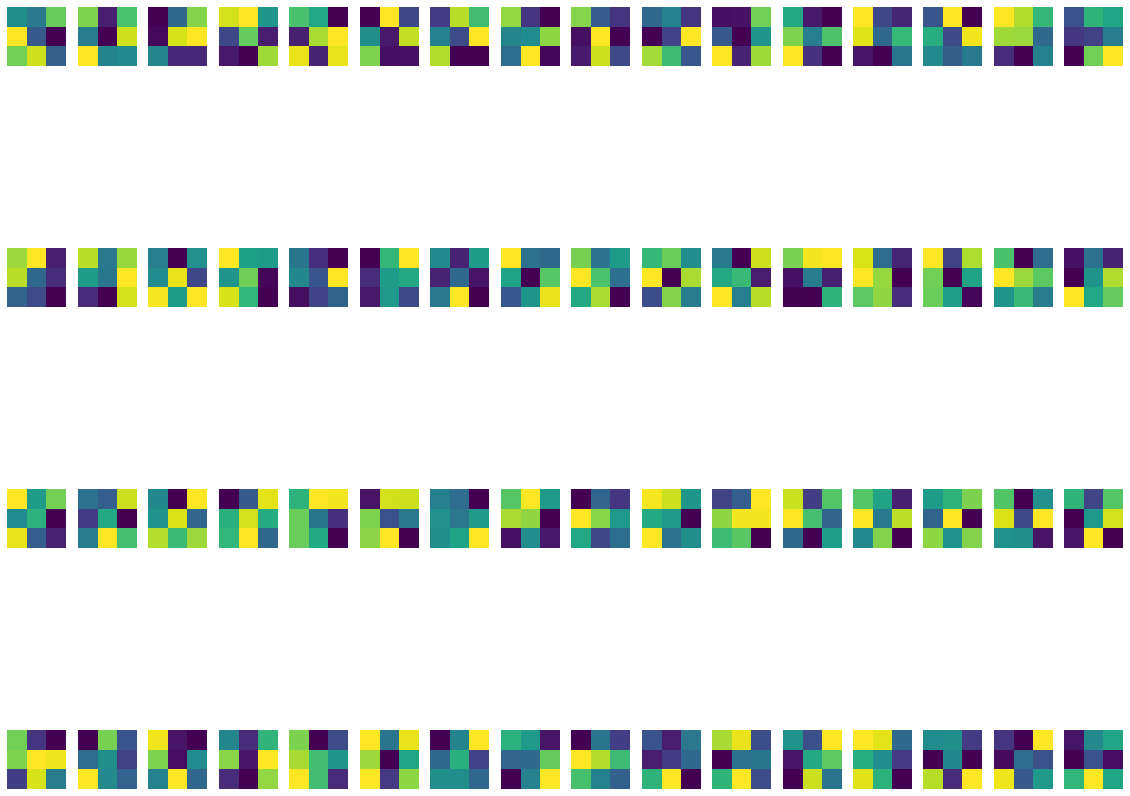

In [26]:
# Kernel filter
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 16, i+1) 
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

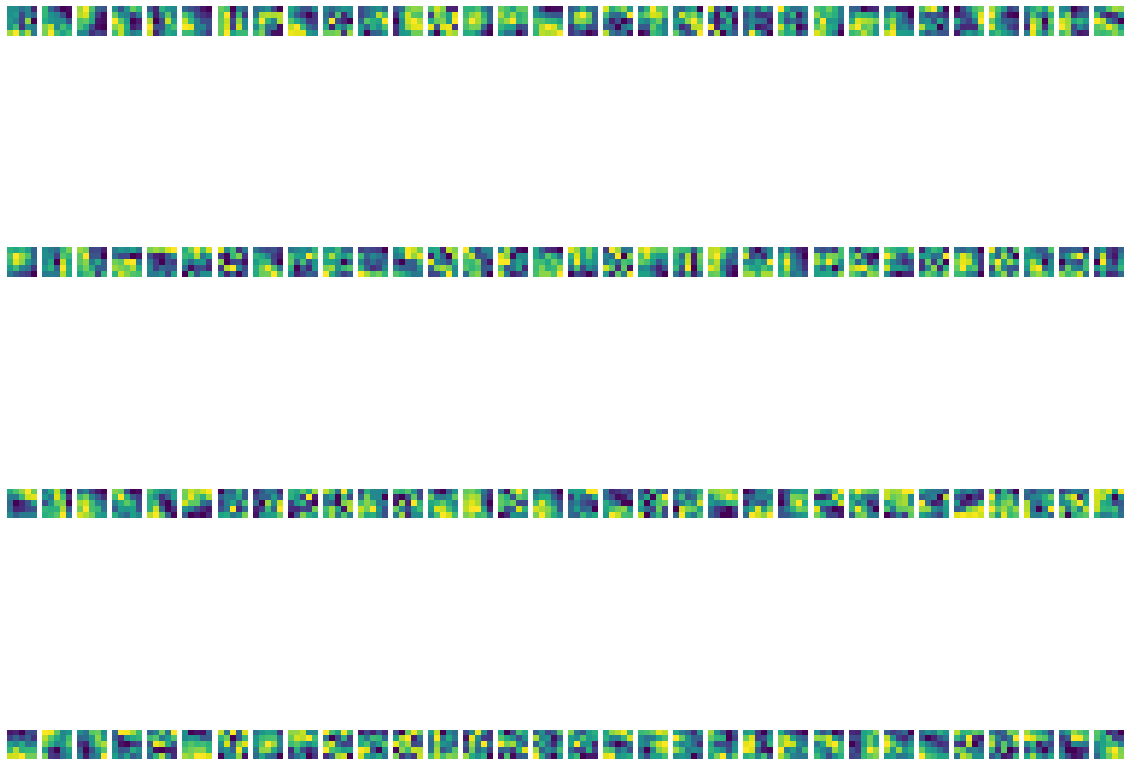

In [27]:
# Kernel filter
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(4, 32, i+1) 
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

torch.Size([128, 5, 5])
16   8
0
1
2
3


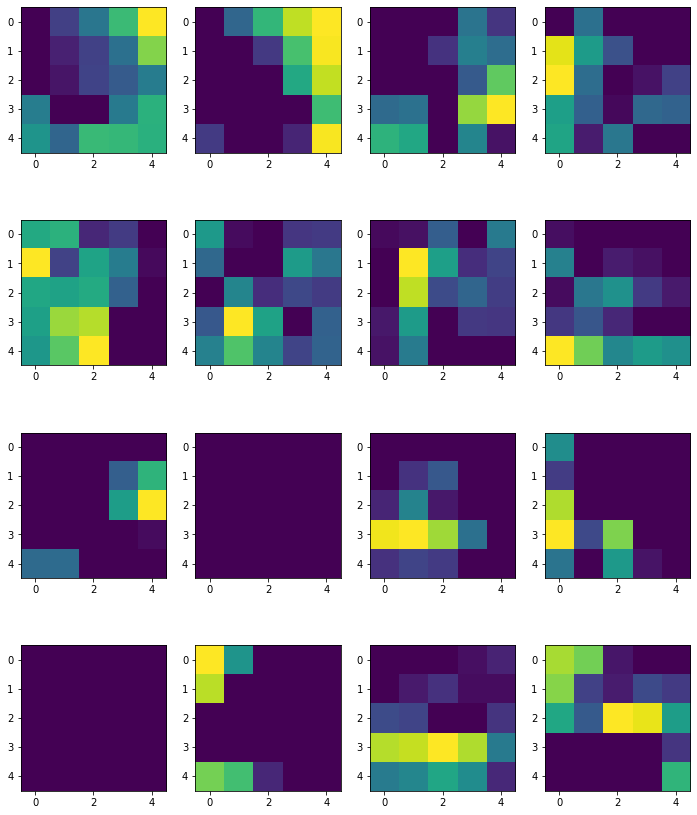

In [28]:
#Activation Map of the second convolution layer
activation = {}
def getActivation(name):
  # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

h1 = cnn.conv1.register_forward_hook(getActivation('conv1'))
h2 = cnn.conv2.register_forward_hook(getActivation('conv2'))

data, _ = Train_Data[4]
data=data.to(device)
data.unsqueeze_(0)
output = cnn(data)

k=0
act = activation['conv1'].squeeze()
# print(act.size())
# print(act.size(0)//8," ",act.size(0)//16)
fig,ax = plt.subplots(4,4,figsize=(12, 15))

# print(act[0].detach().cpu().numpy())

for i in range(4):
        # print(i)
        for j in range(4):
          #  print(j)
           ax[i,j].imshow(act[k].detach().cpu().numpy(),cmap='virdis')
           k+=1
           plt.savefig('fm1.png')
plt.show()

In [ ]:
k=0
act = activation['conv2'].squeeze()
# print(act.size())
# print(act.size(0)//8," ",act.size(0)//16)
fig,ax = plt.subplots(4,4,figsize=(12, 15))

# print(act[0].detach().cpu().numpy())

for i in range(4):
        # print(i)
        for j in range(4):
          #  print(j)
           ax[i,j].imshow(act[k].detach().cpu().numpy(),cmap='binary')
           k+=1
           plt.savefig('fm2.png')
plt.show()

Train Accuracy: 0.31876
Test Accuracy: 0.2006


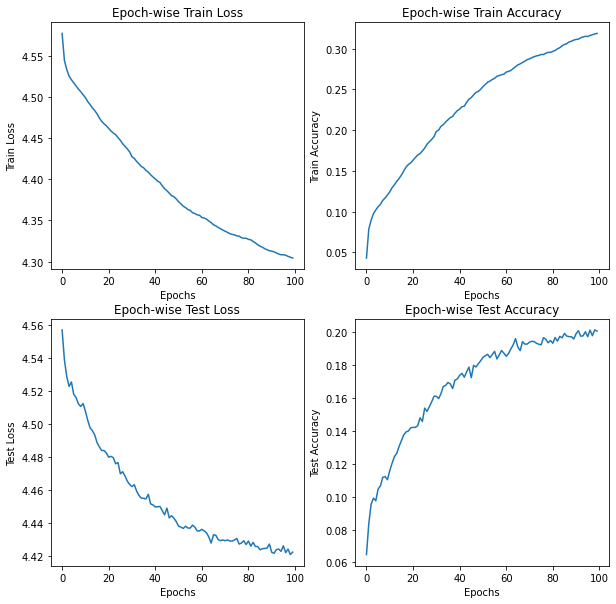

In [29]:

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Epoch-wise Train Loss")
plt.plot(training_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Train Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,2)
plt.title("Epoch-wise Train Accuracy")
plt.plot(training_accuracy_per_epoch)
print("Train Accuracy:",(training_accuracy_per_epoch[-1]) )
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Train Accuracy', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,3)
plt.title("Epoch-wise Test Loss")
plt.plot(testing_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Test Loss', fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,4)
plt.title("Epoch-wise Test Accuracy")
plt.plot(testing_accuracy_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Test Accuracy', fontsize=10)
print("Test Accuracy:",(testing_accuracy_per_epoch[-1]) )

Train Accuracy: 0.31876


Text(0, 0.5, 'Accuracy')

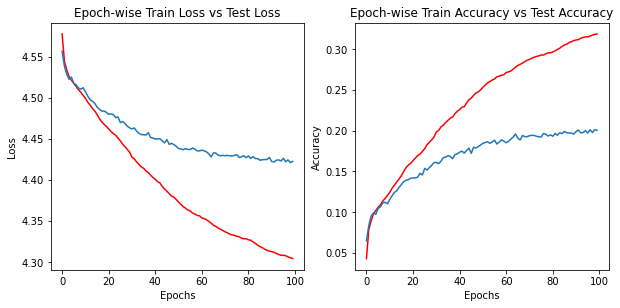

In [30]:
fig1 = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Epoch-wise Train Loss vs Test Loss")
plt.plot(training_loss_per_epoch, color ='red')
plt.plot(testing_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(2,2,2)
plt.title("Epoch-wise Train Accuracy vs Test Accuracy")
plt.plot(training_accuracy_per_epoch, color ='red')
plt.plot(testing_accuracy_per_epoch)
print("Train Accuracy:",(training_accuracy_per_epoch[-1]) )
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

In [31]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

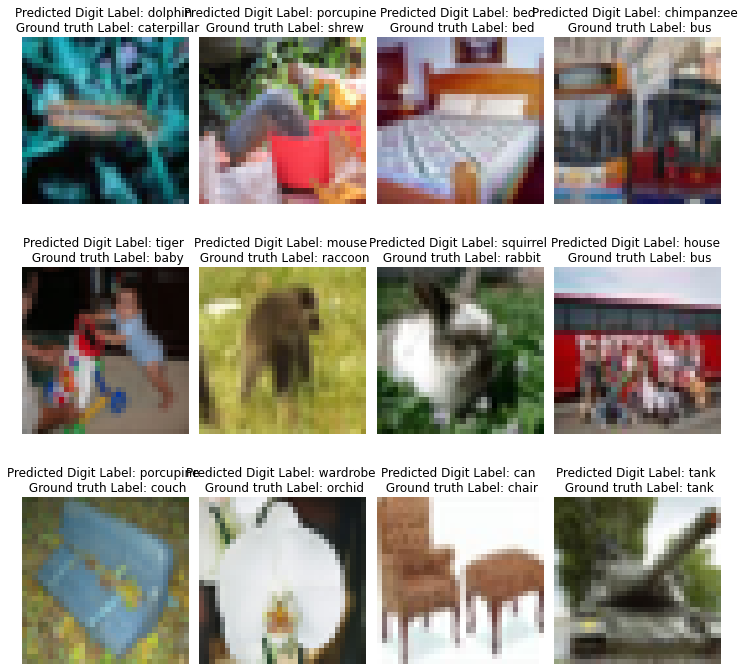

In [32]:
# Plot ten samples with prediction
data = next(iter(Train_Loader))
inputs, labels = data[0:10]
inputs=inputs.to(device)
labels=labels.to(device)
outputs = cnn(inputs)
_, predicted = torch.max(outputs.data,1)
# print(predicted)
# print(labels)
meta_file = r'./data/cifar-100-python/meta'
meta_data = unpickle(meta_file)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10))

i = 0
for ax in axs.reshape(-1):
    ax.set_title("Predicted Digit Label: %s \n Ground truth Label: %s" % (meta_data['fine_label_names'][predicted[i]] , meta_data['fine_label_names'][labels[i]]))
    ax.imshow((inputs.cpu().numpy())[i].transpose(1,2,0), cmap=plt.cm.gray, origin='upper', interpolation='nearest')

    ax.axis('off')
    i += 1
plt.tight_layout()   
plt.show()